## Import Libraries



In [209]:
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files
import time

## Define Transformation Matrices

In [210]:
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


def dRx(q):
    T = np.array([[0,          0,          0, 0],
                  [0, -np.sin(q), -np.cos(q), 0],
                  [0,  np.cos(q), -np.sin(q), 0],
                  [0,          0,          0, 0]], dtype=float)
    return T


def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


def dRy(q):
    T = np.array([[-np.sin(q), 0,  np.cos(q), 0],
                  [         0, 0,          0, 0],
                  [-np.cos(q), 0, -np.sin(q), 0],
                  [         0, 0,          0, 0]], dtype=float)
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T


def dRz(q):
    T = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                  [ np.cos(q), -np.sin(q), 0, 0],
                  [         0,          0,  0, 0],
                  [         0,          0,  0, 0]], dtype=float)
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTx(x):
    T = np.array([[0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTy(y):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTz(z):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]], dtype=float)
    return T

## Forward Kinematics

In [211]:
def getLinkTransformations(T_base, q_active, q_passive, link):
  toLink1 = np.linalg.multi_dot([T_base, Tx(q_active[0]), Ry(q_passive[0]), Tx(link)])
  toLink2 = np.linalg.multi_dot([toLink1, Ry(q_passive[1]), Tx(link)])

  return toLink1, toLink2

In [212]:
def fkLeg(T_base, T_tool, q_active, q_passive, theta, link):
    # T_base - transform from global coordinate frame to local one of the leg
    # T_tool - transform from the lask joint of the leg to the tool frame
    # a - active joint variable
    # p - passive joint variable
    # t - vitual joint (spring) variable
    # link - link length

    T_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                      ])
    
    T_leg = np.linalg.multi_dot([T_base, T_leg_local, T_tool])
    return T_leg

In [213]:
def fkPantograph(T_base, T_tool, q_active, q_passive, theta, link):
    T = []
    for leg in range(2):
        T_leg = fkLeg(T_base, T_tool, q_active[leg], q_passive[leg], theta, link)
        T.append(T_leg)
    return T

## Inverse Kinematics

In [214]:
def ikPantograph(dz, link):
  # dz - vertical height of the robot
  # dx - horizontal distance from active joint
  dx = np.sqrt(link**2 - (dz**2)/4)
  q1 = np.arccos(dx/link)
  q3 = np.pi - q1
  q2 = q3 - q1
  return q1,q2,q3

## Define Local Stiffness Matrices K11, K12, K21, K22

In [215]:
def elementStiffness11(E, G, d, link):
    S = np.pi*(d**2)/4
    Iy = np.pi*(d**4)/64
    Iz = np.pi*(d**4)/64
    J = Iy + Iz
    
    K = np.array([[E*S/link,                 0,                 0,        0,                 0,                0],
                  [       0, 12*E*Iz/(link**3),                 0,        0,                 0, 6*E*Iz/(link**2)],
                  [       0,                 0, 12*E*Iy/(link**3),        0, -6*E*Iy/(link**2),                0],
                  [       0,                 0,                 0, G*J/link,                 0,                0],
                  [       0,                 0, -6*E*Iy/(link**2),        0,       4*E*Iy/link,                0],
                  [       0,  6*E*Iz/(link**2),                 0,        0,                 0,      4*E*Iz/link]], dtype=float)
    
    return K


def elementStiffness12(E, G, d, link):
    S = np.pi*(d**2)/4
    Iy = np.pi*(d**4)/64
    Iz = np.pi*(d**4)/64
    J = Iy + Iz
    
    K = np.array([[-E*S/link,                 0,                 0,        0,                 0,                0],
                  [        0,-12*E*Iz/(link**3),                 0,        0,                 0, 6*E*Iz/(link**2)],
                  [        0,                 0,-12*E*Iy/(link**3),        0, -6*E*Iy/(link**2),                0],
                  [        0,                 0,                 0,-G*J/link,                 0,                0],
                  [        0,                 0,  6*E*Iy/(link**2),        0,       2*E*Iy/link,                0],
                  [        0, -6*E*Iz/(link**2),                 0,        0,                 0,      2*E*Iz/link]], dtype=float)
    
    return K


def elementStiffness22(E, G, d, link):
    S = np.pi*(d**2)/4
    Iy = np.pi*(d**4)/64
    Iz = np.pi*(d**4)/64
    J = Iy + Iz
    
    K = np.array([[E*S/link,                 0,                 0,        0,                 0,                0],
                  [       0, 12*E*Iz/(link**3),                 0,        0,                 0,-6*E*Iz/(link**2)],
                  [       0,                 0, 12*E*Iy/(link**3),        0,  6*E*Iy/(link**2),                0],
                  [       0,                 0,                 0, G*J/link,                 0,                0],
                  [       0,                 0,  6*E*Iy/(link**2),        0,       4*E*Iy/link,                0],
                  [       0, -6*E*Iz/(link**2),                 0,        0,                 0,      4*E*Iz/link]], dtype=float)
    
    return K

## VJM

In [216]:
def JacobianPassiveLeg(T_fk, T_base, T_tool, q_active, q_passive, theta, link):
    T_fk[0:3, 3] = 0
    inv_T_fk = np.transpose(T_fk)

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                        Tx(theta[0]), # 1 DOF virtual spring
                                        dRy(q_passive[0]), # passive joint
                                        Tx(link), # rigid link
                                        Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                        Ry(q_passive[1]), # passive joint
                                        Tx(link), # rigid link 
                                        Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                        Ry(q_passive[2]), # passive joint
                                        Tx(q_active[1])
                                        ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J1 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    
    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                        Tx(theta[0]), # 1 DOF virtual spring
                                        Ry(q_passive[0]), # passive joint
                                        Tx(link), # rigid link
                                        Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                        dRy(q_passive[1]), # passive joint
                                        Tx(link), # rigid link 
                                        Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                        Ry(q_passive[2]), # passive joint
                                        Tx(q_active[1])
                                        ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J2 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    
    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                        Tx(theta[0]), # 1 DOF virtual spring
                                        Ry(q_passive[0]), # passive joint
                                        Tx(link), # rigid link
                                        Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                        Ry(q_passive[1]), # passive joint
                                        Tx(link), # rigid link 
                                        Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                        dRy(q_passive[2]), # passive joint
                                        Tx(q_active[1])
                                        ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J3 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    J = np.hstack([J1, J2, J3])
    return J


def JacobianPassivePantograph(T_base, T_tool, q_active, q_passive, theta, link):
    T_fk = fkPantograph(T_base, T_tool, q_active, q_passive, theta, link)

    Jq = []
    for leg in range(2):
        J = JacobianPassiveLeg(T_fk[leg], T_base, T_tool, q_active[leg], q_passive[leg], theta, link)
        Jq.append(J)
    return Jq

In [217]:
def JacobianThetaLeg(T_fk, T_base, T_tool, q_active, q_passive, theta, link):
    T_fk[0:3, 3] = 0
    inv_T_fk = np.transpose(T_fk)

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       dTx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J1 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       dTx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J2 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), dTy(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J3 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), dTz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J4 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])
    
    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), dRx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J5 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), dRy(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J6 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), dRz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J7 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       dTx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J8 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), dTy(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J9 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), dTz(theta[9]), Rx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J10 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), dRx(theta[10]), Ry(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J11 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), dRy(theta[11]), Rz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J12 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    dT_leg_local = np.linalg.multi_dot([Tx(q_active[0]), # active joint 
                                       Tx(theta[0]), # 1 DOF virtual spring
                                       Ry(q_passive[0]), # passive joint
                                       Tx(link), # rigid link
                                       Tx(theta[1]), Ty(theta[2]), Tz(theta[3]), Rx(theta[4]), Ry(theta[5]), Rz(theta[6]), # 6 DOF virtual spring
                                       Ry(q_passive[1]), # passive joint
                                       Tx(link), # rigid link 
                                       Tx(theta[7]), Ty(theta[8]), Tz(theta[9]), Rx(theta[10]), Ry(theta[11]), dRz(theta[12]), # 6 DOF virtual spring
                                       Ry(q_passive[2]), # passive joint
                                       Tx(q_active[1])
                                       ])
    dT_leg = np.linalg.multi_dot([T_base, dT_leg_local, T_tool, inv_T_fk])
    J13 = np.vstack([dT_leg[0, 3], dT_leg[1, 3], dT_leg[2, 3], dT_leg[2, 1], dT_leg[0, 2], dT_leg[1, 0]])

    J = np.hstack([J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, J11, J12, J13])
    return J


def JacobianThetaPantograph(T_base, T_tool, q_active, q_passive, theta, link):
    T_fk = fkPantograph(T_base, T_tool, q_active, q_passive, theta, link)

    Jtheta = []
    for leg in range(2):
        J = JacobianThetaLeg(T_fk[leg], T_base, T_tool, q_active[leg], q_passive[leg], theta, link)
        Jtheta.append(J)
    return Jtheta

## Kc Calculation

In [218]:
def KThetaLeg(K_active, E, G, d, link):
    K0 = np.zeros(13, dtype=float)
    K0[0] = K_active

    zeros_6_1 = np.zeros((6,1), dtype=float)
    zeros_6_6 = np.zeros((6,6), dtype=float)

    K1 = elementStiffness22(E, G, d, link)
    K1 = np.hstack([zeros_6_1, K1, zeros_6_6])

    K2 = elementStiffness22(E, G, d, link)
    K2 = np.hstack([zeros_6_1, zeros_6_6, K2])

    K = np.vstack([K0, K1, K2])
    return K


def KcPantographVJM(Ktheta, Jq, Jtheta):
    Kc_total = []
    for i in range(len(Ktheta)):
        Kc0 = np.linalg.inv(np.linalg.multi_dot([Jtheta[i], np.linalg.inv(Ktheta[i]), np.transpose(Jtheta[i])]))
        Kc = Kc0 - np.linalg.multi_dot([Kc0, Jq[i], np.linalg.inv(np.linalg.multi_dot([np.transpose(Jq[i]), Kc0, Jq[i]])), np.transpose(Jq[i]), Kc0])
        Kc_total.append(Kc)

    Kc_total = Kc_total[0] + Kc_total[1] 
    return Kc_total

## Main Deflection Calculations

In [219]:
def CalculateDeflections(T_base, externalForce, link):

  zlinSpace = np.linspace(0.1, dz_limit, 30)    

  zData = np.array([])
  dData = np.array([])

  with open('VJM_deflection.txt', 'a') as f:
    for dz in zlinSpace:
      q1,q2,q3 = ikPantograph(dz, link)
      q_passive = [np.array([-q1, -q2, q3]), np.array([-q3, q2, q1])]
      dx = np.cos(q1)*link/2
      q_active = [np.array([-dx, dx]), np.array([dx, -dx])]
      Jq = JacobianPassivePantograph(T_base, T_tool, q_active, q_passive, theta, link)
      Jtheta = JacobianThetaPantograph(T_base, T_tool, q_active, q_passive, theta, link)
      Kc = KcPantographVJM(Ktheta, Jq, Jtheta)
      #  print(np.linalg.matrix_rank(Kc))
      #  if np.linalg.matrix_rank(Kc) == 6:
      dt = np.linalg.pinv(Kc).dot(externalForce)
      deflection = np.sqrt(dt[0] ** 2 + dt[1] ** 2 + dt[2] ** 2)
      f.write(str(deflection[0]))
      f.write("\n")

      zData = np.append(zData, dz)
      dData = np.append(dData, deflection)
    
  return zData, dData 

## Plot Pantograph

In [220]:
def plotPantograph(dz, link):
  q1,q2,q3 = ikPantograph(dz, link)
  q_passive = [np.array([-q1, -q2, q3]), np.array([-q3, q2, q1])]
  dx = np.cos(q1)*link/2
  q_active = [np.array([-dx, dx]), np.array([dx, -dx])]

  for i in range(2):
    x = []
    z = []
    toLink1, toLink2 = getLinkTransformations(T_base, q_active[i], q_passive[i], link)
    link_1 = toLink1[0:3, 3]
    link_2 = toLink2[0:3, 3]
  
    x.extend([q_active[i][0], link_1[0], link_2[0]])
    z.extend([0, link_1[2], link_2[2]])
    plt.plot(x, z, color='dimgrey', linewidth=5)
    plt.scatter(x,z, s=100, marker='o', color='purple')
  
  plt.plot([-dx, dx],[0, 0], color='violet', linewidth=3)
  plt.plot([-dx, dx],[dz, dz], color='green', linewidth=3)
  plt.scatter([0, 0],[dz/4, 3*dz/4], s=150, marker='o', color='purple')
  plt.title('Pantograph Model')
  plt.xlabel('x-axis', fontsize=20)
  plt.ylabel('z-axis', fontsize=20)
  plt.xlim([-0.25, 0.25])
  plt.ylim([-0.1, 1])
  plt.grid()
  plt.savefig("Pantograph Model.png")
  plt.show()

## Plot Deflection Map

In [221]:
def plotDeflectionMap(z_pos, deflection, figureName):
  plt.scatter(z_pos, deflection, color = 'red')
  plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
  plt.ylabel('Deflection \u0394t (m)', fontsize=20)
  plt.xlabel('z', fontsize=20)
  plt.savefig(figureName)
  plt.show()

## Initialize Constant Values

In [222]:
link = 0.5 # links length
d = 0.03 # links diameter
dz_limit = 0.9 # Maximum height is 1 m 

T_base = np.eye(4, dtype=float)
T_tool = Ty(0)

theta = np.zeros(13)
# dz = 0.8
# q1,q2,q3 = ikPantograph(dz, link)
# q_passive = [np.array([-q1, -q2, q3]), np.array([-q3, q2, q1])]
# q_active = [np.array([-0.15, 0.15]), np.array([0.15, -0.15])]

K_active = 1000000 # actuator stiffness
E = 7.0000e+10 # Young's modulus
G = 2.5500e+10 # shear modulus

# VJM parameters
Ktheta = KThetaLeg(K_active, E, G, d, link)
Ktheta = [Ktheta, Ktheta]

## Final Output

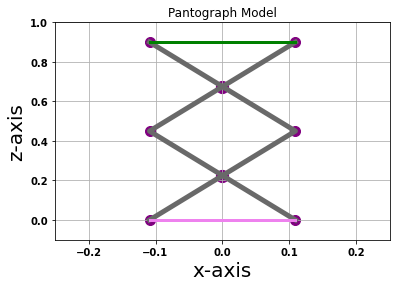

In [223]:
plotPantograph(dz_limit, link)
# files.download("Pantograph Model.png")

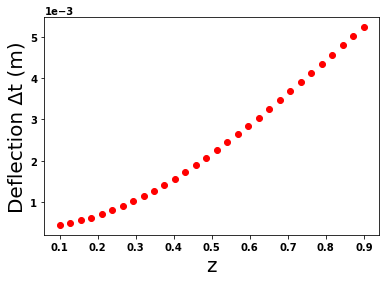

3.905350923538208


In [224]:
externalForce = np.array([[0], [100], [0], [0], [0], [0]])
t = time.time()
z_pos, deflection = CalculateDeflections(T_base, externalForce, link)
figureName = "VJM_DeflectionMap_y.png"
plotDeflectionMap(z_pos, deflection, figureName)
elapsed = time.time() - t
print(elapsed)
# files.download(figureName)